In [1]:
import sys
import os
import glob
import SimpleITK as sitk
import nibabel as nib
from pandas import DataFrame
import numpy as np
from monai.utils import set_determinism
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Spacingd,
    EnsureTyped,
    AsDiscrete,
    EnsureType,
)
from monai.data import DataLoader, Dataset, decollate_batch
from monai.metrics import DiceMetric
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools")
import func.vis.vis as vis

In [2]:
label_dir="/home/local/VANDERBILT/litz/data/luna16/lvlsetseg/"
name = "lvlsetseg_1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd"
label_path = os.path.join(label_dir, name)

In [3]:
def showslice(img, z, y, x, is_gray=False, clip_range=[]):
    clip_ax = img[z, :, :]
    clip_cor = img[:,y,:]
    clip_cor = np.flip(clip_cor, 0)
    clip_sag = img[:,:,x]
    clip_sag = np.flip(clip_sag, 0)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    # fig = plt.figure(1)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))
    if is_gray:
        ax[0].imshow(clip_ax, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        sag = ax[2].imshow(clip_sag, interpolation='nearest', cmap='gray', vmin=vmin, vmax=vmax)
        
    else:
        ax[0].imshow(clip_ax, interpolation='nearest', vmin=vmin, vmax=vmax)
        ax[1].imshow(clip_cor, interpolation='nearest', vmin=vmin, vmax=vmax)
        sag = ax[2].imshow(clip_sag, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(sag, ax=ax[2], fraction=0.046, pad=0.04)

In [4]:
seg_dir = "/home/local/VANDERBILT/litz/data/luna16/johof_fused/"
label_dir = "/home/local/VANDERBILT/litz/data/luna16/fixed_labels/"

In [11]:
def test_dataloader(segs, labels):
    test_files = [
        {"image": seg_name, "label": label_name}
        for seg_name, label_name in zip(segs, labels)
    ]
    # print(test_files)
    set_determinism(1)

    test_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1,1,1), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ])
    test_ds = Dataset(data=test_files, transform=test_transforms)
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)
    print(f"Test sample size: {len(test_ds)}")
    return test_loader

In [12]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0")

In [19]:
seg_names = sorted(glob.glob(os.path.join(seg_dir, "*.mhd")))
label_names = sorted(glob.glob(os.path.join(label_dir, "*.nrrd")))

test_loader = test_dataloader(seg_names, label_names)
test_metric = DiceMetric(include_background=False, reduction="none")

device = torch.device("cuda:0")
post_pred = Compose([EnsureType(), AsDiscrete(to_onehot=6)])
post_labels = Compose([AsDiscrete(to_onehot=6)])


Test sample size: 51


  0%|                                                                                     | 0/51 [00:13<?, ?it/s]


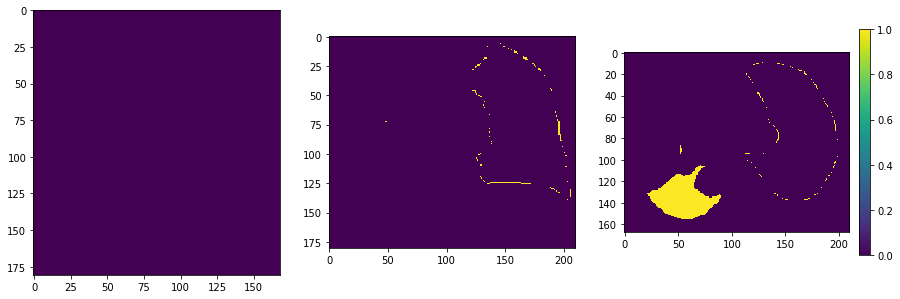

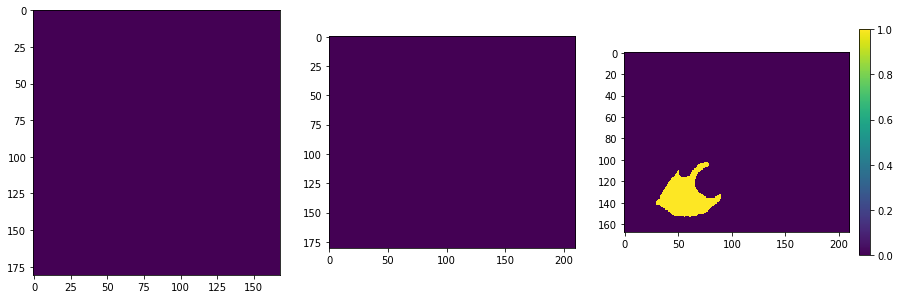

In [22]:
for test_data in tqdm(test_loader):
    seg, label = (test_data["image"].to(device), test_data["label"].to(device))
    # print(decollate_batch(seg))
    seg = [post_pred(i) for i in decollate_batch(seg)]
    # print(seg[0].shape)
    label = [post_labels(i) for i in decollate_batch(label)]
    # print(label[0].shape)
    vis.showslice(seg[0][2, :, :,:].detach().cpu().numpy(), 100,100,100)
    vis.showslice(label[0][2, :,:,:].detach().cpu().numpy(), 100,100,100)
    test_metric(y_pred=seg, y=label)
    break

test_dices = test_metric.aggregate()

# Record metrics and compute mean over test set
class_means = torch.mean(test_dices, dim=0)
mean = torch.mean(test_dices)
test_dices_df = DataFrame(test_dices.detach().cpu().numpy())
# test_dices_df.to_csv(metrics_f)

In [29]:
a = seg[0][5,:,:,:].detach().cpu().numpy()
np.unique(a, return_counts=True)

(array([0., 1.], dtype=float32), array([6122003,  263677]))

In [30]:
test_data = next(iter(test_loader))
seg, label = (test_data["image"], test_data["label"])


In [32]:
print(seg.shape)
np.unique(seg, return_counts=True)

torch.Size([1, 1, 210, 168, 181])


(array([0.0000000e+00, 3.6282157e-17, 4.8585744e-17, ..., 4.9993010e+00,
        4.9997349e+00, 5.0000000e+00], dtype=float32),
 array([4888737,       1,       1, ...,       1,       1,  263677]))

In [96]:
seg_onehot = [post(i) for i in decollate_batch(seg)]
print(seg[0].shape)
label_onehot = [post(i) for i in decollate_batch(label)]
print(label[0].shape)

torch.Size([1, 210, 168, 181])
torch.Size([1, 210, 168, 181])


In [97]:
seg_img = seg[0, 0, :, :, :].detach().cpu().numpy()
label_img = label[0, 0, :, :, :].detach().cpu().numpy()
print(np.unique(seg_img))
print(np.unique(label_img, return_counts=True))

[0.0000000e+00 3.6282157e-17 4.8585744e-17 ... 4.9993010e+00 4.9997349e+00
 5.0000000e+00]
(array([0., 1., 2., 3., 4., 5.], dtype=float32), array([5080444,  327890,  181896,  412875,   92478,  290097]))


In [72]:
set_label = np.where(label_img>8, 0, label_img)
set_label = np.where(set_label==7, 1, set_label)
set_label = np.where(set_label==8, 2, set_label)
set_label = np.where(set_label==4, 3, set_label)
set_label = np.where(set_label==5, 4, set_label)
set_label = np.where(set_label==6, 5, set_label)
print(np.unique(set_label))

[0. 1. 2. 3. 4. 5.]


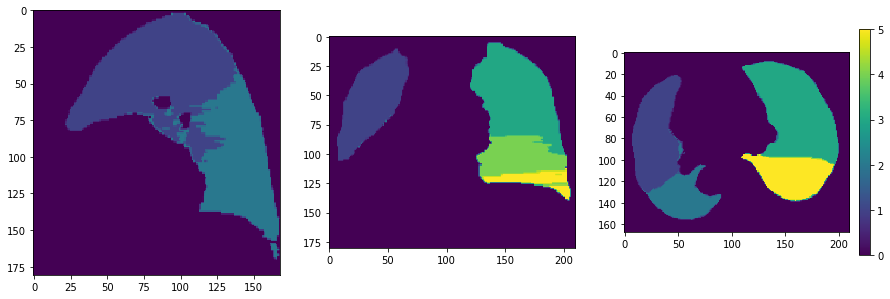

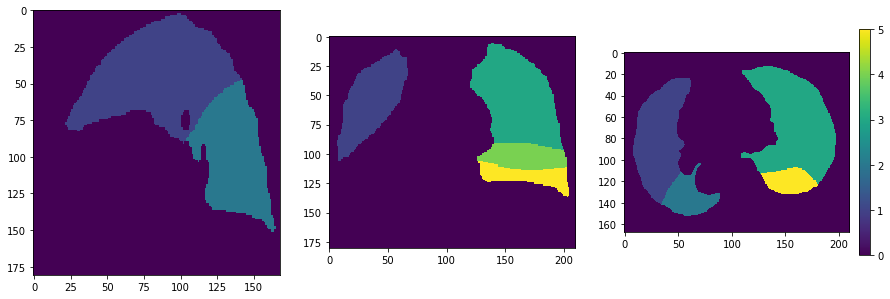

In [100]:
vis.showslice(seg_img, 50,100,100)
vis.showslice(label_img, 50,100,110)
# vis.showslice(label_img, 100,100,110, clip_range=[510, 520])
# vis.showslice(set_label, 50,100,110)

[0.0000000e+00 3.6282157e-17 4.8585744e-17 ... 4.9993010e+00 4.9997349e+00
 5.0000000e+00]
(array([  0.,   4.,   5.,   6.,   7.,   8., 512., 516., 517., 518., 519.,
       520.], dtype=float32), array([5056416,  412875,   92478,  290097,  327890,  181896,   23772,
           127,       9,      65,      19,      36]))


In [50]:
vlsp_label_dir = "/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/"
vlsp_name = "lvlsetseg_00002008time20180920.nii.gz"
johof_dir = "/nfs/masi/SPORE/lobe/JoHof/fusedswap"
johof_name = "lobe_00002008time20180920.nii.gz"
vlsp_label_path = os.path.join(vlsp_label_dir, vlsp_name)
johof_path = os.path.join(johof_dir, johof_name)
vlsp_nii = nib.load(vlsp_label_path)
vlsp_img = vlsp_nii.get_fdata()
johof_img = nib.load(johof_path).get_fdata()


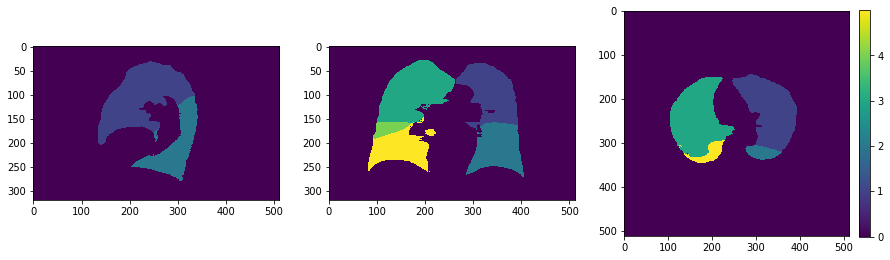

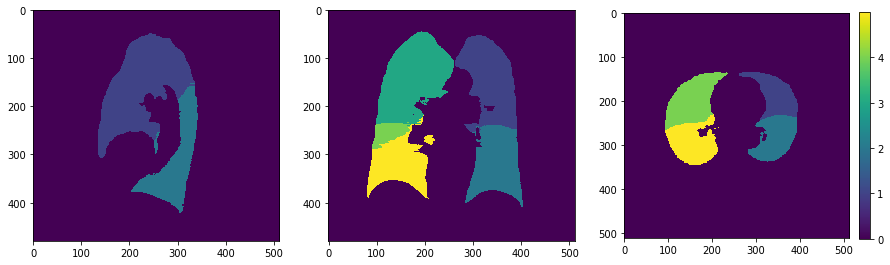

In [51]:
vis.showslice(vlsp_img, 300,250,200)
vis.showslice(johof_img, 300,250,200)

In [78]:
fixed_path = "/home/local/VANDERBILT/litz/data/luna16/fixed_labels/1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456_LobeSegmentation.nrrd"
fixed_sitk = sitk.ReadImage(fixed_path)
fixed_img = sitk.GetArrayFromImage(fixed_sitk)


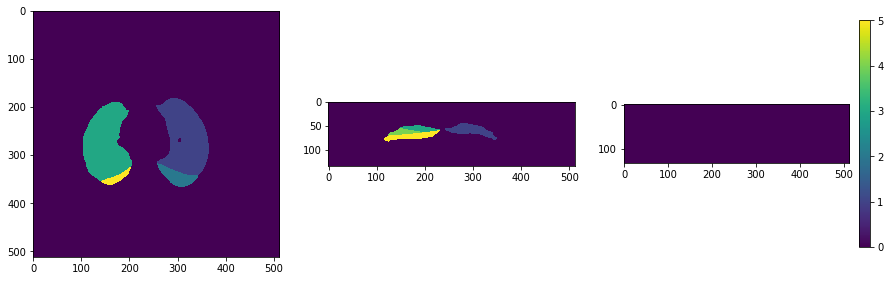

In [90]:
showslice(fixed_img, 100,160,50)

In [16]:
preproc_dir = "/home/local/VANDERBILT/litz/data/luna16/preproc_labeled_raw/"
raw_dir = "/home/local/VANDERBILT/litz/data/luna16/labeled_raw/"
name = "1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd"
raw_path = os.path.join(raw_dir, name)
preproc_path = os.path.join(preproc_dir, name)
preproc_sitk = sitk.ReadImage(preproc_path)
preproc_img = sitk.GetArrayFromImage(preproc_sitk)
raw_sitk = sitk.ReadImage(raw_path)
raw_img = sitk.GetArrayFromImage(raw_sitk)

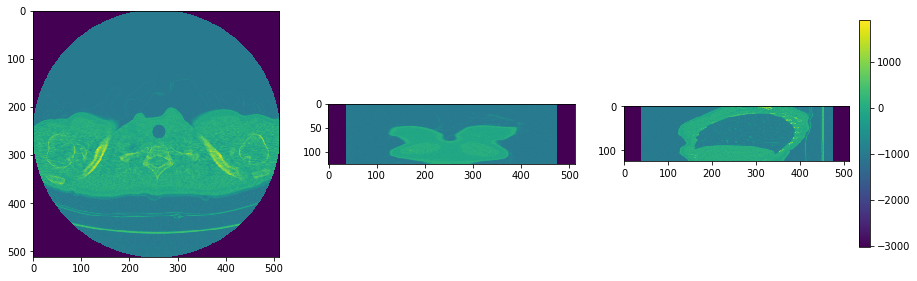

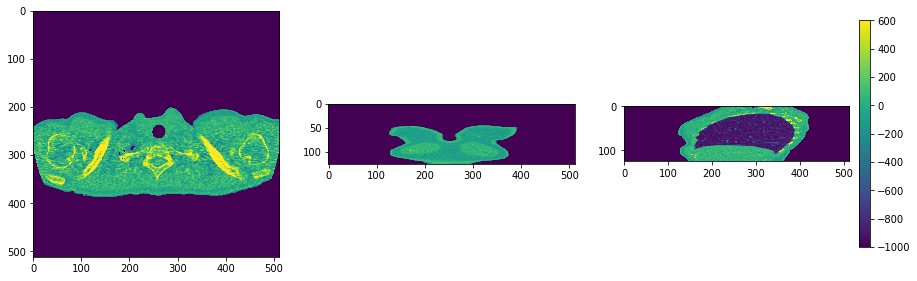

In [17]:

showslice(raw_img, 120,120,120)
showslice(preproc_img, 120,120,120, clip_range=[-1000, 600])
